# Anomaly Detection

In [1]:
# import sys
import sys
sys.path.append("/home/ladin/Projects/research/botnet-traffic-analysis/")

# Jupyter data visualization
from IPython import display

# data handling
from sklearn.preprocessing import normalize
from sklearn.utils import resample
import numpy as np
import pandas as pd

# machine learning
from sklearn.ensemble import RandomForestClassifier

# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import plot, axis, show, pcolor, colorbar, bone
from scipy.stats import gaussian_kde

# SOM
import minisom
import somoclu
from SAD.anomaly_detection import AnomalyDetection

# hyperparameter tuning
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp

# feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# other
import time
import os

In [2]:
from utils.datasets import get_all_files

In [3]:
def plot_som(som, data, target=None):
    plt.figure(figsize=(16, 12))
    bone()
    pcolor(som.distance_map().T)
    colorbar()
    markers = ['o','s','D','+','v','p','*','x']
    colors = ['r','g','b','y','pink','orange','purple','grey']
    if target is not None:
        for cnt, xx in enumerate(data):
            w = som.winner(xx)
            plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor='None',
                markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)
            axis([0, som._weights.shape[0], 0, som._weights.shape[1]])
        show()
    else:
        for cnt, xx in enumerate(data):
            w = som.winner(xx)
            plot(w[0]+.5, w[1]+.5, markers[0], markerfacecolor='None',
                markeredgecolor=colors[0], markersize=12, markeredgewidth=2)
        show()

## Malware detection via Training and Tuning SOMs

In [4]:
# Load data
from utils.config import dn_nbaiot, nbaiot_1K_data_path, nbaiot_5K_data_path, nbaiot_10K_data_path, nbaiot_20K_data_path
from utils.datasets import get_all_files

In [5]:
choose_folder = nbaiot_5K_data_path
all_files = get_all_files(folder=choose_folder)

In [9]:
def get_data_by_device_type(index):
    device_file = [file for file in all_files if str(index) in file]
    df_benign = pd.DataFrame()
    df_attack = pd.DataFrame()
#     df_ack = pd.DataFrame()
#     df_scan = pd.DataFrame()
#     df_syn = pd.DataFrame()
#     df_udp = pd.DataFrame()
    for filename in device_file:
        df_c = pd.read_csv(os.path.join(choose_folder, filename))
        rows = df_c.shape[0]
        if 'benign' in filename:
            df_benign = pd.concat([df_benign.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        else:
            df_attack = pd.concat([df_attack.iloc[:, :].reset_index(drop=True),
                                  df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
#         if 'ack' in filename:
#             df_ack = pd.concat([df_ack.iloc[:, :].reset_index(drop=True),
#                              df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
#         if 'scan' in filename:
#             df_scan = pd.concat([df_scan.iloc[:, :].reset_index(drop=True),
#                              df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
#         if 'syn' in filename:
#             df_syn = pd.concat([df_syn.iloc[:, :].reset_index(drop=True),
#                              df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
#         if 'udp' in filename:
#             df_udp = pd.concat([df_udp.iloc[:, :].reset_index(drop=True),
#                              df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
#     return df_benign, df_ack, df_scan, df_sync, df_udp
    return df_benign, df_attack
#     print(device_file)

In [10]:
# df_benign, df_ack, df_scan, df_syn, df_udp = get_data_by_device_type(1)
df_benign, df_attack = get_data_by_device_type(1)

In [11]:
# preprocess data
df_benign['class'] = 0
df_attack['class'] = 1
# df_ack['class'] = 1
# df_scan['class'] = 2
# df_syn['class'] = 3
# df_udp['class'] = 4

In [12]:
data_benign = normalize(df_benign.iloc[:, 0:-1])
data_attack = normalize(df_attack.iloc[:, 0: -1])
# data_ack = normalize(df_ack.iloc[:, 0:-1])
# data_scan = normalize(df_scan.iloc[:, 0:-1])
# data_syn = normalize(df_syn.iloc[:, 0:-1])
# data_udp = normalize(df_udp.iloc[:, 0:-1])

In [13]:
target_benign = df_benign.iloc[:, -1].astype(int)
target_attack = df_attack.iloc[:, -1].astype(int)
# target_ack = df_ack.iloc[:, -1].astype(int)
# target_scan = df_scan.iloc[:, -1].astype(int)
# target_syn = df_syn.iloc[:, -1].astype(int)
# target_udp = df_udp.iloc[:, -1].astype(int)

In [14]:
df_benign.head()

,Unnamed: 0,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,class
0,0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0
1,1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,...,0.0,0.0,5.319895,344.262695,4.710446,344.262695,22.188299,0.0,0.0,0
2,2,1.857879,360.458980,35.789338,1.912127,360.275733,35.923972,1.969807,360.091968,35.991542,...,0.0,0.0,6.318264,347.703087,9.034660,347.703087,81.625077,0.0,0.0,0
3,3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,...,0.0,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,0
4,4,1.680223,172.140917,18487.448750,1.793580,182.560279,18928.175300,1.925828,193.165753,19153.795810,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0


In [15]:
df_attack.head()

,Unnamed: 0,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,class
0,0,1.000000,98.000000,0.000000e+00,1.000000,98.000000,0.000000,1.000000,98.000000,0.000000e+00,...,0.0,0.0,1.000000,98.0,0.000000,98.000000,0.000000e+00,0.0,0.0,1
1,1,1.029000,98.000000,1.818989e-12,1.119520,98.000000,0.000000,1.492583,98.000000,3.637979e-12,...,0.0,0.0,1.992944,98.0,0.000001,138.592929,1.818989e-12,0.0,0.0,1
2,2,1.504156,76.725612,2.281808e+02,1.729662,79.499272,249.746357,2.294102,84.051188,2.517926e+02,...,0.0,0.0,1.000000,66.0,0.000000,114.856432,0.000000e+00,0.0,0.0,1
3,3,2.460087,75.617679,1.372200e+02,2.699075,77.461807,164.269331,3.280499,80.987267,1.964467e+02,...,0.0,0.0,1.000000,74.0,0.000000,74.000000,0.000000e+00,0.0,0.0,1
4,4,3.460055,75.150149,9.809937e+01,3.699054,76.525944,122.224798,4.280490,79.354915,1.592943e+02,...,0.0,0.0,1.000000,74.0,0.000000,74.000000,0.000000e+00,0.0,0.0,1


In [16]:
# data = np.vstack([data_benign, data_ack, data_scan, data_syn, data_udp])
# target = np.hstack([target_benign, target_ack, target_scan, target_syn, target_udp])

data = np.vstack([data_benign, data_attack])
target = np.hstack([target_benign, target_attack])

In [17]:
# shuffle
data = resample(data)
target = resample(target)

In [18]:
print(np.isnan(data).any())
print(np.isnan(target).any())

False
False


# Creating and training SOM

In [19]:
n = 5000
x = int(1/2*np.sqrt(n))
som_og = minisom.MiniSom(x=x,
                        y=x,
                        input_len=data_benign.shape[1],
                        sigma=2,
                        learning_rate=0.5)

In [20]:
som_og.train_random(data_benign, 100)

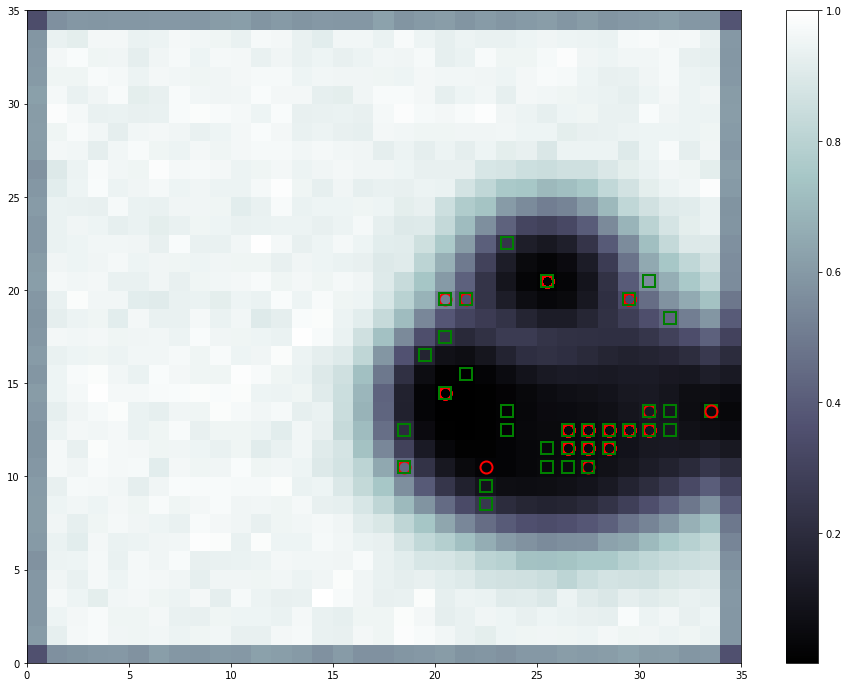

In [21]:
plot_som(som_og, data[0:n, :], target[0:n])

# Tree-based feature selection

In [22]:
clf = ExtraTreesClassifier()
clf.fit(data, target)

ExtraTreesClassifier()

In [23]:
sfm = SelectFromModel(clf, prefit=True)

In [26]:
data_benign_new = sfm.transform(data_benign)
data_attack_new = sfm.transform(data_attack)
# data_ack_new = sfm.transform(data_ack)
# data_scan_new = sfm.transform(data_scan)
# data_syn_new = sfm.transform(data_syn)
# data_udp_new = sfm.transform(data_udp)
data_new = sfm.transform(data)

In [27]:
print("Number of feature: ", data_new.shape[1])

Number of feature:  14


In [28]:
space = {
    'sigma': hp.uniform('sigma', 5, 10),
    'learning_rate': hp.uniform('learning_rate', 0.05, 5),
    'x': hp.uniform('x', 20, 50)
}

In [29]:
def som_fn(space):
    sig = space['sigma']
    learning_rate = space['learning_rate']
    x = int(space['x'])
    val = minisom.MiniSom(x=x,
                         y=x,
                         input_len=data_benign_new.shape[1],
                         sigma=sig,
                         learning_rate=learning_rate,
                         ).quantization_error(data_benign_new[0:100, :])
    print(space)
    print(val)
    return {'loss': val, 'status': STATUS_OK}

In [30]:
trials = Trials()

In [31]:
best = fmin(fn=som_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=1200,
           trials=trials)

{'learning_rate': 3.2933625717270734, 'sigma': 6.298720602326416, 'x': 38.29237808921862}
0.8715083102610574                                      
{'learning_rate': 3.6261548018338736, 'sigma': 8.719070992016213, 'x': 31.784589057827304}
0.9318081008211379                                                                
{'learning_rate': 0.8241486895701561, 'sigma': 7.916516545598961, 'x': 29.142742959190006}
0.933182187092186                                                                 
{'learning_rate': 1.3147528078240525, 'sigma': 6.193794539839103, 'x': 21.722058447852454}
0.9545335648143035                                                                
{'learning_rate': 1.760248838476763, 'sigma': 7.680183862835311, 'x': 48.862838559420666}
0.8767771110831041                                                                
{'learning_rate': 2.751818419171705, 'sigma': 8.855716359539798, 'x': 44.2232661295193}
0.9146068025951953                                                    

{'learning_rate': 1.7528477904592643, 'sigma': 9.968778452853655, 'x': 23.351822447020233}
0.9328308247024133                                                                 
{'learning_rate': 2.7040405343222615, 'sigma': 5.864461476554106, 'x': 33.55439886907177}
0.8947895046659956                                                                 
{'learning_rate': 4.177055174711676, 'sigma': 8.812023661107292, 'x': 35.71834133108601}
0.8547797901524911                                                                 
{'learning_rate': 3.7744232601180467, 'sigma': 7.2679775600745575, 'x': 38.084418316686175}
0.9026817244629032                                                                 
{'learning_rate': 2.0207859429416217, 'sigma': 6.355223595353877, 'x': 45.200703552468354}
0.9255816265397381                                                                 
{'learning_rate': 0.5735179688361713, 'sigma': 8.962831951210815, 'x': 48.92810841833996}
0.9057941674168859                   

{'learning_rate': 3.714572225424901, 'sigma': 7.013833171131153, 'x': 34.3919501675235}
0.916665817232881                                                                  
{'learning_rate': 1.8812491947156145, 'sigma': 9.557115943333823, 'x': 39.53827447333028}
0.9161038537248705                                                                 
{'learning_rate': 3.9131264259175937, 'sigma': 7.440574541798669, 'x': 40.73750218222945}
0.9091784666887937                                                                 
{'learning_rate': 3.879303230593112, 'sigma': 7.8032107364001835, 'x': 22.119122441356406}
0.9454476274935107                                                                 
{'learning_rate': 2.7739649119187115, 'sigma': 9.140838240240582, 'x': 28.072483166569864}
0.8707964150341574                                                                 
{'learning_rate': 3.496775351619302, 'sigma': 7.6416718520844125, 'x': 48.30137277222505}
0.8948579429721497                      

0.9149840705174593                                                                  
{'learning_rate': 0.8818266489424957, 'sigma': 9.866973865241512, 'x': 36.36317896219774}
0.9590719216011443                                                                  
{'learning_rate': 4.472440188595732, 'sigma': 6.892113340995052, 'x': 39.12766232049599}
0.8232886174878032                                                                  
{'learning_rate': 0.5238952062871514, 'sigma': 6.851621793198924, 'x': 42.63211058526045}
0.890091562868988                                                                   
{'learning_rate': 4.50644393993142, 'sigma': 5.300733228714025, 'x': 46.76036995878355}
0.9113492245424439                                                                  
{'learning_rate': 4.989559291227284, 'sigma': 5.909176649489414, 'x': 38.32260552073319}
0.9235234563763757                                                                  
{'learning_rate': 3.88178609323639, 'sigma':

0.8958158798216362                                                                  
{'learning_rate': 3.4277715938929934, 'sigma': 6.810883005011924, 'x': 42.28883023388912}
0.8807629414662206                                                                  
{'learning_rate': 2.7844969183963624, 'sigma': 6.006561733453945, 'x': 38.527886587749485}
0.9296576338820348                                                                  
{'learning_rate': 1.358406565819982, 'sigma': 5.005469881447606, 'x': 35.97373931278591}
0.877311412333511                                                                   
{'learning_rate': 3.002347245201112, 'sigma': 8.25140219653853, 'x': 37.056015139444426}
0.9229153355144872                                                                  
{'learning_rate': 4.466242631253646, 'sigma': 8.406401684472009, 'x': 37.65364141509721}
0.9518065428669407                                                                  
{'learning_rate': 4.8594967727239355, 'sig

{'learning_rate': 1.2442667004549333, 'sigma': 6.705647724984751, 'x': 43.18806004470829}
0.9368663386099481                                                                  
{'learning_rate': 0.31549241588097643, 'sigma': 6.9412969496138714, 'x': 47.87918607480066}
0.9145495920281782                                                                  
{'learning_rate': 1.4803586251226295, 'sigma': 6.602626898524642, 'x': 42.59556837877328}
0.9172084077985312                                                                  
{'learning_rate': 0.6854776130537191, 'sigma': 7.182637049901492, 'x': 21.242533058112432}
0.9741954301154057                                                                  
{'learning_rate': 1.001449925427591, 'sigma': 7.441385518780322, 'x': 39.72304407209004}
0.9260344866052247                                                                  
{'learning_rate': 1.3906550669198676, 'sigma': 5.799671775070455, 'x': 44.35827520934333}
0.9080521517262716               

0.8888607932796094                                                                  
{'learning_rate': 1.7928807784773575, 'sigma': 6.542392521564651, 'x': 40.665085282352884}
0.8981038714569332                                                                  
{'learning_rate': 2.8194102393147116, 'sigma': 6.442235028490646, 'x': 48.98021301008655}
0.9126693296494729                                                                  
{'learning_rate': 2.378749231687277, 'sigma': 8.196541363529382, 'x': 49.98278742918619}
0.8935787282448446                                                                  
{'learning_rate': 3.0559138946705247, 'sigma': 7.607339063735707, 'x': 41.51996492872955}
0.9305120583713139                                                                  
{'learning_rate': 2.6236212640775443, 'sigma': 6.820620098709081, 'x': 38.8426001352624}
0.9133103931379639                                                                  
{'learning_rate': 4.529583243264764, 'sig

{'learning_rate': 2.8233146027806724, 'sigma': 7.475858992963601, 'x': 41.410065686235725}
0.9086327126534935                                                                  
{'learning_rate': 4.1664662917624335, 'sigma': 7.728139823487393, 'x': 25.971386000512627}
0.9130783978589088                                                                  
{'learning_rate': 3.6808493110128415, 'sigma': 9.25836798426462, 'x': 45.66540431066853}
0.8887312954433209                                                                  
{'learning_rate': 1.345500224364293, 'sigma': 7.396056882501563, 'x': 37.98615193773762}
0.9301261891447229                                                                  
{'learning_rate': 2.948872630090905, 'sigma': 7.186213868037022, 'x': 49.11152218058963}
0.9085456822803137                                                                  
{'learning_rate': 2.5749626317403917, 'sigma': 8.409280460956845, 'x': 34.68349260279536}
0.9405586388126501                  

0.9157520401299389                                                                  
{'learning_rate': 4.224137406011088, 'sigma': 6.998963867095461, 'x': 49.90875578595124}
0.9166076078623572                                                                  
{'learning_rate': 0.5930941431765052, 'sigma': 6.427010815151234, 'x': 36.10076732763966}
0.9076085509157135                                                                  
{'learning_rate': 0.9188621119550222, 'sigma': 7.945463110618945, 'x': 26.81823490734942}
0.8777536774424779                                                                  
{'learning_rate': 3.4871086462313823, 'sigma': 6.062465960882072, 'x': 46.69622492925486}
0.8646510040365392                                                                  
{'learning_rate': 1.6611431391042595, 'sigma': 7.510982235563697, 'x': 43.30850512973487}
0.8869024721620294                                                                  
{'learning_rate': 2.7221709838879304, 'si

{'learning_rate': 3.484518989328638, 'sigma': 7.005029654346204, 'x': 43.033560051791504}
0.9031990955099096                                                                  
{'learning_rate': 3.9974496289022414, 'sigma': 7.192772937497369, 'x': 45.522563186289396}
0.9023262058538961                                                                  
{'learning_rate': 3.746292125595661, 'sigma': 7.787390420652959, 'x': 42.109449215760456}
0.9235692905633661                                                                  
{'learning_rate': 4.976951565917764, 'sigma': 7.3081597027496255, 'x': 47.092300339774944}
0.9065273771887975                                                                  
{'learning_rate': 3.091456781757786, 'sigma': 6.696399437427372, 'x': 41.51541803754374}
0.905003228629417                                                                   
{'learning_rate': 3.3068048693708985, 'sigma': 6.842170716404371, 'x': 46.71404877681463}
0.87532360162803                  

0.8661370880731252                                                                  
{'learning_rate': 4.727221356129739, 'sigma': 7.604079604276927, 'x': 44.01060736827364}
0.9082092476012873                                                                  
{'learning_rate': 3.9283554202357975, 'sigma': 7.940660269291493, 'x': 46.05095969290221}
0.859650786561101                                                                   
{'learning_rate': 3.485897664005479, 'sigma': 8.207702083897539, 'x': 42.5543435401479}
0.9212533467998847                                                                  
{'learning_rate': 2.897847403988163, 'sigma': 8.38177265978018, 'x': 40.301845995340805}
0.9088811339693259                                                                  
{'learning_rate': 2.691161162727207, 'sigma': 9.700294290230724, 'x': 45.11356761551541}
0.9250535242618676                                                                  
{'learning_rate': 3.7903282153821745, 'sigma'

0.8870858468593069                                                                  
{'learning_rate': 3.710896656059054, 'sigma': 8.433694362787396, 'x': 38.70983613112942}
0.8346960099231001                                                                  
{'learning_rate': 4.055357811692781, 'sigma': 9.419845352848718, 'x': 36.82559531000681}
0.9176324026707534                                                                  
{'learning_rate': 3.812836856538995, 'sigma': 8.304259421496543, 'x': 33.970164529461286}
0.8954150528062672                                                                  
{'learning_rate': 4.8807862761139225, 'sigma': 9.589012767283196, 'x': 33.40154400906028}
0.9052314527607288                                                                  
{'learning_rate': 4.303788032541356, 'sigma': 8.912513887276836, 'x': 39.09495944398231}
0.8852969109026092                                                                  
{'learning_rate': 3.594443712794161, 'sigma

0.9259267965960302                                                                  
{'learning_rate': 4.004774922150342, 'sigma': 8.731093657463068, 'x': 40.003053643218706}
0.9109727025943312                                                                  
{'learning_rate': 4.800219196119827, 'sigma': 8.485729973392344, 'x': 34.22150437458703}
0.933518995368413                                                                   
{'learning_rate': 4.230481569422013, 'sigma': 5.150073689640869, 'x': 41.81077818835951}
0.8828682772826112                                                                  
{'learning_rate': 3.718483361512828, 'sigma': 7.959125435972781, 'x': 40.889265934715645}
0.903004930328892                                                                   
{'learning_rate': 3.556577891269266, 'sigma': 8.233284073037131, 'x': 20.649944670970527}
0.9329930375137476                                                                  
{'learning_rate': 4.370990661397658, 'sigm

{'learning_rate': 2.8004473677038155, 'sigma': 8.498734093535875, 'x': 37.351978264360426}
0.9032261544334331                                                                  
{'learning_rate': 3.2155302980316525, 'sigma': 8.589692215640957, 'x': 39.20464491121457}
0.9280819238796528                                                                  
{'learning_rate': 3.8680966336685323, 'sigma': 9.047516689017318, 'x': 40.102026700734605}
0.9257693242781195                                                                  
{'learning_rate': 4.061085672976871, 'sigma': 8.301855769171915, 'x': 40.51090141693195}
0.8808803013098655                                                                  
{'learning_rate': 3.4408545068623795, 'sigma': 8.63472513528178, 'x': 39.711719601692884}
0.8966292917424487                                                                  
{'learning_rate': 4.16865912068309, 'sigma': 9.094215781472858, 'x': 35.62909351042969}
0.9318543022426583                  

0.8881690431131412                                                                  
{'learning_rate': 3.0033811860566084, 'sigma': 8.888333425250389, 'x': 46.27249150150968}
0.9005197680091903                                                                  
{'learning_rate': 3.2561111263612266, 'sigma': 7.793399948912134, 'x': 36.78564297557321}
0.8870398888742741                                                                  
{'learning_rate': 3.851032690177608, 'sigma': 8.467506565675437, 'x': 28.23262670737076}
0.911357567557469                                                                   
{'learning_rate': 3.097112856933541, 'sigma': 9.257684527466832, 'x': 39.1326099924543}
0.9247922931190748                                                                  
{'learning_rate': 2.853551076517446, 'sigma': 8.016651139260057, 'x': 45.76414628989538}
0.8459970824613532                                                                  
{'learning_rate': 2.3900865980494133, 'sigma

{'learning_rate': 2.722171980176169, 'sigma': 8.023329252103355, 'x': 45.60079668623555}
0.8865869073933866                                                                  
{'learning_rate': 2.9257519829861574, 'sigma': 7.731612340286111, 'x': 45.195853902495664}
0.8366528893177134                                                                  
{'learning_rate': 2.431929551708219, 'sigma': 7.804721078591851, 'x': 47.27759529396662}
0.9310760409073747                                                                  
{'learning_rate': 3.067154133689772, 'sigma': 8.191424930197913, 'x': 44.54860306200708}
0.9017224755047271                                                                  
{'learning_rate': 2.2814606438853557, 'sigma': 7.924051306861188, 'x': 45.69554829342978}
0.9150132870862105                                                                  
{'learning_rate': 3.1820925597377325, 'sigma': 7.660311114428437, 'x': 46.01782295361658}
0.9081178733893762                   

0.8945397700414897                                                                  
{'learning_rate': 2.59907971109593, 'sigma': 7.674118949219865, 'x': 49.04486564883062}
0.909172376404457                                                                   
{'learning_rate': 3.346164952414712, 'sigma': 8.00625572757735, 'x': 24.043725301462835}
0.9340128651905976                                                                  
{'learning_rate': 2.7195474263870665, 'sigma': 7.761473314482225, 'x': 44.065083490251205}
0.9002222219696406                                                                  
{'learning_rate': 3.743014936501244, 'sigma': 8.102185593389347, 'x': 45.77368260226982}
0.929297248090106                                                                   
{'learning_rate': 3.8668155977955614, 'sigma': 8.320237440902986, 'x': 47.17929866191206}
0.8848612408177426                                                                  
{'learning_rate': 3.2132817441793295, 'sigm

{'learning_rate': 2.8035449340676015, 'sigma': 8.651224697552164, 'x': 42.1269313144889}
0.9136814244305336                                                                  
{'learning_rate': 2.5843541350401655, 'sigma': 8.159781203098312, 'x': 40.886201983653486}
0.9067253716197564                                                                  
{'learning_rate': 2.8942804294765807, 'sigma': 8.245719950974527, 'x': 39.78525453289061}
0.9084338861133623                                                                  
{'learning_rate': 3.3202621449411467, 'sigma': 8.060227447331835, 'x': 39.1470579815377}
0.89201628806133                                                                    
{'learning_rate': 2.4026440861927147, 'sigma': 8.558571289299614, 'x': 43.735914444170476}
0.8983188952268679                                                                  
{'learning_rate': 3.038547760415305, 'sigma': 8.45317894499515, 'x': 41.59372097008135}
0.8652010290477149                   

0.9118317545036833                                                                  
{'learning_rate': 3.6394474082624084, 'sigma': 7.472291241174324, 'x': 47.59488917175493}
0.913761413055525                                                                   
{'learning_rate': 3.9343567631213396, 'sigma': 8.067127936086058, 'x': 37.90448377262685}
0.9353184467930309                                                                  
{'learning_rate': 4.062095371170696, 'sigma': 8.865792157253395, 'x': 39.77225071198498}
0.9256967667284043                                                                  
{'learning_rate': 3.322826691621028, 'sigma': 8.30291522177857, 'x': 40.71292069185874}
0.9172244584472696                                                                  
{'learning_rate': 3.0400831432258406, 'sigma': 8.65981399891629, 'x': 41.585698499566355}
0.8871482833653976                                                                  
{'learning_rate': 3.5608529154646744, 'sigm

{'learning_rate': 3.983138272990685, 'sigma': 7.216354040827762, 'x': 46.099822871259974}
0.8710315914024354                                                                  
{'learning_rate': 3.8434625560012385, 'sigma': 7.014649640297651, 'x': 48.373103945342194}
0.9102363072865711                                                                  
{'learning_rate': 3.688282649129041, 'sigma': 7.327697868183133, 'x': 49.252043011934354}
0.9147547617517353                                                                  
{'learning_rate': 4.475564827388574, 'sigma': 7.525593502274441, 'x': 46.552303558305894}
0.8795018631143495                                                                  
{'learning_rate': 3.2793554245542818, 'sigma': 7.590248546833691, 'x': 47.5691983858325}
0.8950458078514643                                                                  
{'learning_rate': 3.538584925491562, 'sigma': 7.444233671135467, 'x': 45.364895281863646}
0.9188365584817939                 

0.8573439066422565                                                                  
{'learning_rate': 4.108843747931378, 'sigma': 7.861657597177144, 'x': 29.392463887339957}
0.9112399410539187                                                                  
{'learning_rate': 3.3736118672686266, 'sigma': 8.3401972537644, 'x': 43.58959949543396}
0.8660246937713694                                                                  
{'learning_rate': 3.6255441336892296, 'sigma': 6.686457856719902, 'x': 44.67490572018018}
0.9136987343154337                                                                  
{'learning_rate': 4.368020000520996, 'sigma': 8.138091647218298, 'x': 42.05577393108477}
0.8856150120692388                                                                  
{'learning_rate': 3.254971288096477, 'sigma': 7.763784744332904, 'x': 47.28790401564053}
0.8895482663324722                                                                  
{'learning_rate': 3.7670617970178926, 'sigma

{'learning_rate': 3.4811250269338685, 'sigma': 7.979387331898252, 'x': 48.05422604389709}
0.8344465641954869                                                                  
{'learning_rate': 2.6260651531406816, 'sigma': 6.959454900412569, 'x': 43.16630130477914}
0.9357102480700754                                                                  
{'learning_rate': 2.8584137158452028, 'sigma': 7.71134713691305, 'x': 34.8914669047615}
0.9307277932933777                                                                  
{'learning_rate': 3.163881205792423, 'sigma': 7.587393485446047, 'x': 46.343819162278}
0.880098258595942                                                                   
{'learning_rate': 3.8060053369819262, 'sigma': 7.051010850442644, 'x': 45.415019051178206}
0.8717056054383187                                                                  
{'learning_rate': 3.2293788123560248, 'sigma': 6.55114950679878, 'x': 33.39319217387779}
0.9238154488348078                      

0.8807155774424436                                                                   
{'learning_rate': 4.54372935194696, 'sigma': 8.321405505443382, 'x': 44.58544177403531}
0.8941463146606553                                                                   
{'learning_rate': 4.678447042043513, 'sigma': 8.143375328551066, 'x': 44.17456969344569}
0.8905737027884263                                                                   
{'learning_rate': 4.508803960843701, 'sigma': 8.406697813548996, 'x': 43.49151634684043}
0.8934493464443534                                                                   
{'learning_rate': 4.735621743021929, 'sigma': 8.48567800017312, 'x': 43.758345712909524}
0.9188805918572391                                                                   
{'learning_rate': 4.33417440070516, 'sigma': 7.988090454809413, 'x': 45.3602660414723}
0.8506820291312306                                                                   
{'learning_rate': 4.948375635413785, 'sigm

{'learning_rate': 4.162310546927666, 'sigma': 8.166028965238985, 'x': 45.69290064701932}
0.8873722853565149                                                                   
{'learning_rate': 3.3186878542006797, 'sigma': 7.702652569584437, 'x': 41.755443507073686}
0.8795317296528957                                                                   
{'learning_rate': 4.5096888096467564, 'sigma': 8.597356177684656, 'x': 46.47431561291332}
0.8852087094171117                                                                   
{'learning_rate': 3.225349929610862, 'sigma': 7.506035555623188, 'x': 44.00716874299608}
0.8199324877410483                                                                   
{'learning_rate': 3.784732039906148, 'sigma': 8.238377821805319, 'x': 48.4607626984595}
0.8885479927373956                                                                   
{'learning_rate': 3.417077388577927, 'sigma': 8.40124935490139, 'x': 42.76280930991331}
0.9290270654836401                 

0.9297836540546999                                                                   
{'learning_rate': 3.6133342190110107, 'sigma': 8.434653361125184, 'x': 45.68050756733566}
0.9108271142909794                                                                   
{'learning_rate': 3.059885331282905, 'sigma': 7.714852023448542, 'x': 48.21981753081457}
0.9050516929440556                                                                   
{'learning_rate': 2.7261794780179236, 'sigma': 7.156554657130512, 'x': 47.05409225182704}
0.884128017576105                                                                    
{'learning_rate': 3.7462753813440606, 'sigma': 8.823821718255749, 'x': 49.410224821211315}
0.8924965137827884                                                                   
{'learning_rate': 3.948227678102919, 'sigma': 7.344090048645913, 'x': 45.25511858259771}
0.9222144506732225                                                                   
{'learning_rate': 3.465973266386013

{'learning_rate': 2.490391876307008, 'sigma': 7.610757157398561, 'x': 47.2297663514002}
0.8423470639601639                                                                   
{'learning_rate': 2.957109519143853, 'sigma': 7.0421209969005805, 'x': 45.59246662575795}
0.920509747500188                                                                    
{'learning_rate': 2.7122666925289614, 'sigma': 8.029950771574976, 'x': 44.74788117545807}
0.8429402569447736                                                                   
{'learning_rate': 2.801377983418461, 'sigma': 7.772082308735999, 'x': 46.204572105039816}
0.8417984569375696                                                                   
{'learning_rate': 2.167461633088445, 'sigma': 8.088983542795495, 'x': 47.684892877718774}
0.9182759460097283                                                                   
{'learning_rate': 4.050900514468173, 'sigma': 7.229703511804046, 'x': 49.26817065944846}
0.9020504305359044               

In [32]:
print('Best: {}'.format(best))

Best: {'learning_rate': 3.7098871084475347, 'sigma': 8.330844983909081, 'x': 48.133505461453595}


In [33]:
som_turned = minisom.MiniSom(x=48,
                            y=48,
                            input_len=data_benign_new.shape[1],
                            sigma=8.330844983909081,
                            learning_rate=3.7098871084475347)

In [34]:
som_turned.train_random(data_benign_new, 1000)

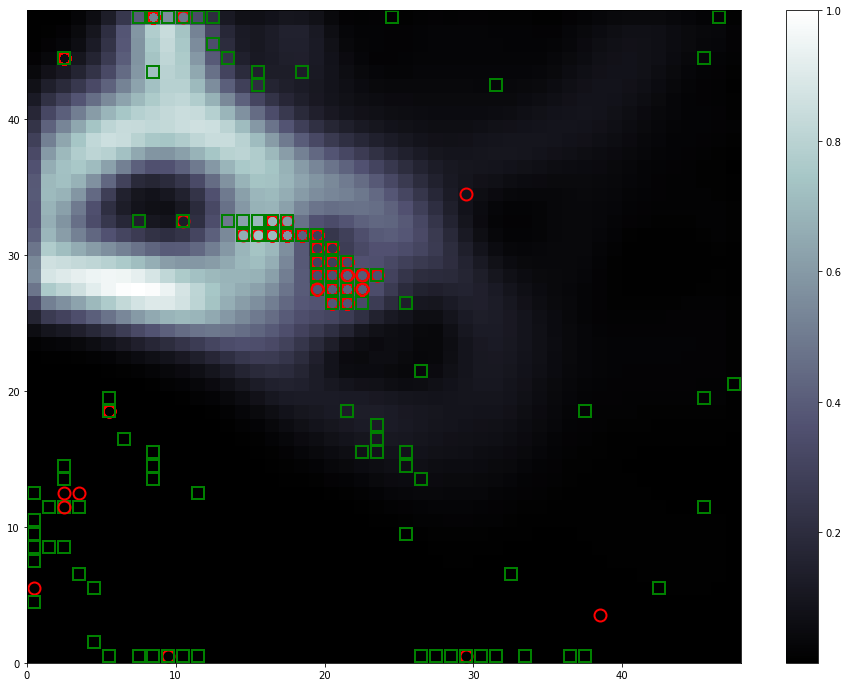

In [35]:
n = 10000
plot_som(som_turned, data_new[0:n, :], target[0:n])

## Somoclu

Flexible library with many options.

Pros:
- easy to identify clusters
- PCA initialization instead of random
- includes K-means clustering algorithm from sklearn
- evolving maps

Cons:
- long time to train.

In [36]:
som_somoclu = somoclu.Somoclu(n_columns=48,
                             n_rows=48,
                             std_coeff=8.3,
                             verbose=1)

In [37]:
som_somoclu.train(data_new[0:1000, :],
                 scale0=0.2,
                 scaleN=0.02)

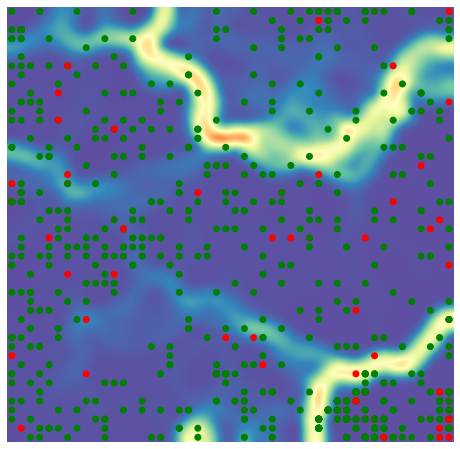

<module 'matplotlib.pyplot' from '/home/ladin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [38]:
colors = ['red', 'green', 'blue', 'pink', 'yellow']
color_list = [colors[t] for t in target[0:1000]]
som_somoclu.view_umatrix(bestmatches=True, bestmatchcolors=color_list)

# Anomaly detection with SOM and K-nearest neighbors

In [39]:
def get_anomalies(benign_metrics, anomaly_metrics, alpha=3, return_outliers=True):
    '''
    Get anomalies from evaluation metric
    '''
    limit = np.mean(benign_metrics)+np.std(benign_metrics)*alpha
    outliers = np.argwhere(np.abs(anomaly_metrics) > limit)
    print("Determined: ", len(outliers)/len(anomaly_metrics)*100, "% as anomaly")
    if return_outliers:
        return outliers

In [40]:
def minimize_anomaly(benign_metrics, anomaly_metrics, alpha=3):
    '''
    Objective function to be minimized durinig tuning
    calculates percent error in classifying anomalies based on steady state metrics.
    '''
    limit = np.mean(benign_metrics) + np.std(benign_metrics)*alpha
    outliers = np.argwhere(np.abs(anomaly_metrics)>limit)
    pct_anomaly = len(outliers)/len(anomaly_metrics)
    return 1 - pct_anomaly

In [77]:
# print(minimize_anomaly(benign_metrics=benign_metrics, anomaly_metrics=anomaly_metrics))

In [41]:
training = data_benign_new
evaluation = data_new

In [42]:
# initialize our anomaly detector with some arbitrary parameters
anomaly_detector = AnomalyDetection(shape=(10,10),
                                   input_size=training.shape[1],
                                   learning_rate=8,
                                   learning_decay=0.001,
                                   initial_radius=2,
                                   radius_decay=0.001,
                                   min_number_per_bmu=0,
                                   number_of_neighbors=3)
# fit the anomaly detector and apply to the evaluation data
anomaly_detector.fit(training, 5000)

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


array([[9.84831056e-01, 1.54330103e-05, 2.73250543e-05, ...,
        8.16840761e-16, 6.12992332e-06, 1.83632486e-04],
       [9.82236340e-01, 9.40250534e-06, 1.80192707e-05, ...,
        1.37860728e-15, 7.13731771e-06, 1.32177933e-04],
       [9.77475104e-01, 8.42820871e-06, 1.73560949e-05, ...,
        1.99484196e-08, 1.45611928e-05, 5.50598577e-04],
       ...,
       [1.04943262e-01, 4.42378603e-04, 1.10555665e-03, ...,
        2.82416784e-04, 3.80088525e-03, 9.73750682e-01],
       [1.31925553e-02, 1.34950418e-05, 3.91145411e-05, ...,
        2.37281174e-05, 5.31491960e-04, 9.98901263e-01],
       [2.16686653e-03, 4.30894484e-06, 7.51198381e-06, ...,
        3.61944115e-06, 9.10131935e-05, 9.99937054e-01]])

In [43]:
# set limits
benign_metrics = anomaly_detector.evaluate(data_benign_new)
alpha = 3
sd_benign = np.std(benign_metrics)
mean_benign = np.mean(benign_metrics)
lim_benign = mean_benign + alpha*sd_benign
pct_benign = np.percentile(benign_metrics, 99.7)

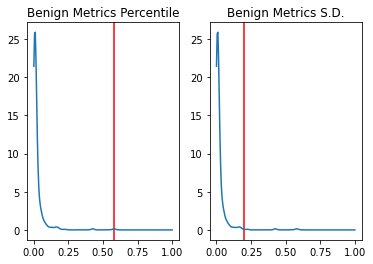

In [44]:
# visualizing benign
density = gaussian_kde(benign_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Benign Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Benign Metrics S.D.")
plt.show()

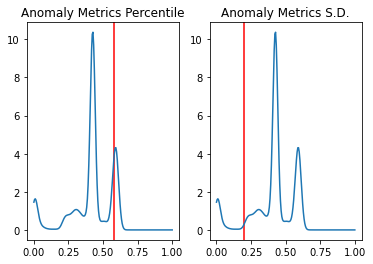

In [45]:
# Visualizing all anomalies
anomaly_metrics = anomaly_detector.evaluate(evaluation)
density = gaussian_kde(anomaly_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Anomaly Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Anomaly Metrics S.D.")
plt.show()

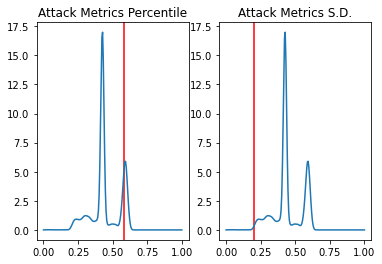

In [46]:
# Visualizing all attack
attack_metrics = anomaly_detector.evaluate(data_attack_new)
density = gaussian_kde(attack_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Attack Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Attack Metrics S.D.")
plt.show()

In [47]:
# # Visualizing all anomalies
# scan_metrics = anomaly_detector.evaluate(data_scan_new)
# density = gaussian_kde(scan_metrics)
# plt.subplot(121)
# plt.axvline(x=pct_benign, color='red')
# xs = np.linspace(0, 1, 200)
# plt.plot(xs, density(xs))
# plt.title("Scan Metrics Percentile")
# plt.subplot(122)
# plt.axvline(x=lim_benign, color='red')
# xs = np.linspace(0, 1, 200)
# plt.plot(xs, density(xs))
# plt.title("Scan Metrics S.D.")
# plt.show()

In [48]:
# # Visualizing all anomalies
# syn_metrics = anomaly_detector.evaluate(data_syn_new)
# density = gaussian_kde(syn_metrics)
# plt.subplot(121)
# plt.axvline(x=pct_benign, color='red')
# xs = np.linspace(0, 1, 200)
# plt.plot(xs, density(xs))
# plt.title("Syn Metrics Percentile")
# plt.subplot(122)
# plt.axvline(x=lim_benign, color='red')
# xs = np.linspace(0, 1, 200)
# plt.plot(xs, density(xs))
# plt.title("Syn Metrics S.D.")
# plt.show()

In [49]:
# # Visualizing all anomalies
# udp_metrics = anomaly_detector.evaluate(data_udp_new)
# density = gaussian_kde(udp_metrics)
# plt.subplot(121)
# plt.axvline(x=pct_benign, color='red')
# xs = np.linspace(0, 1, 200)
# plt.plot(xs, density(xs))
# plt.title("Udp Metrics Percentile")
# plt.subplot(122)
# plt.axvline(x=lim_benign, color='red')
# xs = np.linspace(0, 1, 200)
# plt.plot(xs, density(xs))
# plt.title("Udp Metrics S.D.")
# plt.show()

In [58]:
metrics = [benign_metrics, anomaly_metrics, attack_metrics] # anomaly_metrics, ack_metrics, scan_metrics, syn_metrics, udp_metrics]
metric_names = ['benign', 'all alnomalies', 'attack'] # 'ack', 'scan', 'syn', 'udp']
alpha = 3
for metric, name in zip(metrics, metric_names):
    print(name)
    get_anomalies(benign_metrics, metric, alpha, False)

benign
Determined:  1.3599999999999999 % as anomaly
all alnomalies
Determined:  90.79272727272726 % as anomaly
attack
Determined:  99.862 % as anomaly


# Hyperparameter tuning

In [51]:
import time
start_time = time.time()

space = {
    'n_neighbors': hp.uniform('n_neighbors', 1, 3),
    'learning_rate': hp.uniform('learning_rate', 0.005, 10),
    'learning_decay': hp.uniform('learning_decay', 0.00001, 0.1),
    'initial_radius': hp.uniform('initial_radius', 1, 10),
    'radius_decay': hp.uniform('radius_decay', 0.00001, 0.1),
    'x': hp.uniform('x', 10, 50),
    'minNumberPerBmu': hp.uniform('minNumberPerBmu', 0, 10)
}

In [52]:
def anomaly_fn(space):
    n_neighbors = int(space['n_neighbors'])
    learning_rate = space['learning_rate']
    learning_decay = space['learning_decay']
    initial_radius = int(space['initial_radius'])
    radius_decay = space['radius_decay']
    x = int(space['x'])
    minNumberPerBmu = int(space['minNumberPerBmu'])
    
    anomaly_detector = AnomalyDetection(shape=(x, x),
                                       input_size=training.shape[1],
                                       learning_rate=learning_rate,
                                       learning_decay=learning_decay,
                                       initial_radius=initial_radius,
                                       radius_decay=radius_decay,
                                       min_number_per_bmu=minNumberPerBmu,
                                       number_of_neighbors=n_neighbors)
    anomaly_detector.fit(training, 5000)
    a_metrics = anomaly_detector.evaluate(evaluation)
    b_metrics = anomaly_detector.evaluate(training)
    val = minimize_anomaly(b_metrics, a_metrics, alpha=3)
    
    print(space)
    print(val)
    return {'loss': val, 'status': STATUS_OK}

In [53]:
trials = Trials()
best = fmin(fn=anomaly_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=100,
           trials=trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.914211009297993, 'learning_decay': 0.05204497361354933, 'learning_rate': 8.93261277080383, 'minNumberPerBmu': 1.941278506476194, 'n_neighbors': 1.707155106102626, 'radius_decay': 0.04930474250852851, 'x': 33.565510459304946}
0.1719090909090909                                     
  1%|          | 1/100 [00:04<07:13,  4.38s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.958566317519224, 'learning_decay': 0.005001568551984501, 'learning_rate': 2.348742241261389, 'minNumberPerBmu': 1.5922817123252642, 'n_neighbors': 2.6167731116470136, 'radius_decay': 0.06301188381734951, 'x': 15.475138608964901}
0.24272727272727268                                                              
  2%|▏         | 2/100 [00:06<05:01,  3.08s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.32373569130291, 'learning_decay': 0.04982379032139055, 'learning_rate': 6.3413074951248305, 'minNumberPerBmu': 9.901820284029936, 'n_neighbors': 2.8884734220708568, 'radius_decay': 0.09424450332116102, 'x': 20.207234627629415}
0.2185636363636364                                                               
  3%|▎         | 3/100 [00:09<04:45,  2.94s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.552629563885809, 'learning_decay': 0.0219836252451527, 'learning_rate': 1.7558151510847158, 'minNumberPerBmu': 6.762989638090491, 'n_neighbors': 1.7241258352658486, 'radius_decay': 0.07530114887516645, 'x': 40.41733167191176}
0.22969090909090906                                                              
  4%|▍         | 4/100 [00:15<06:55,  4.33s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.936779112515762, 'learning_decay': 0.0442116995453127, 'learning_rate': 4.142396493603663, 'minNumberPerBmu': 7.720074058524073, 'n_neighbors': 2.5179255136101943, 'radius_decay': 0.007439343717912514, 'x': 39.085513732507664}
0.20330909090909088                                                              
  5%|▌         | 5/100 [00:21<07:35,  4.79s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.6603440788679609, 'learning_decay': 0.007967904325895779, 'learning_rate': 1.2170073558763281, 'minNumberPerBmu': 0.8617763046616478, 'n_neighbors': 1.792275370040171, 'radius_decay': 0.056497301467593686, 'x': 26.337086264115605}
0.8776181818181819                                                               
  6%|▌         | 6/100 [00:25<07:21,  4.70s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.076984987067167, 'learning_decay': 0.032582376194187565, 'learning_rate': 3.843581075037256, 'minNumberPerBmu': 8.197292689986803, 'n_neighbors': 2.7630077185835997, 'radius_decay': 0.08190978782279731, 'x': 16.22502026711754}
0.21894545454545455                                                              
  7%|▋         | 7/100 [00:28<06:01,  3.89s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.361226382592771, 'learning_decay': 0.02934273591168394, 'learning_rate': 6.325345939506718, 'minNumberPerBmu': 7.040342422887217, 'n_neighbors': 2.374414889923017, 'radius_decay': 0.08372426926538086, 'x': 45.430814109115644}
0.24565454545454546                                                              
  8%|▊         | 8/100 [00:34<07:20,  4.79s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.063851470954161, 'learning_decay': 0.0520186561194992, 'learning_rate': 3.680108799985587, 'minNumberPerBmu': 8.24177962962258, 'n_neighbors': 2.9080829390576977, 'radius_decay': 0.06325991075350085, 'x': 10.486062698135648}
0.2235454545454545                                                               
  9%|▉         | 9/100 [00:36<05:50,  3.85s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.173999791700565, 'learning_decay': 0.0246336502651912, 'learning_rate': 0.75100871957826, 'minNumberPerBmu': 2.447977003295012, 'n_neighbors': 2.407840400981889, 'radius_decay': 0.08874755210784463, 'x': 20.37326802725946}
0.22969090909090906                                                              
 10%|█         | 10/100 [00:39<05:15,  3.50s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.0758527013292825, 'learning_decay': 0.07794638592278375, 'learning_rate': 0.6738403621717327, 'minNumberPerBmu': 1.7712098991508274, 'n_neighbors': 1.3839290227369652, 'radius_decay': 0.07240766532152801, 'x': 28.632681975585783}
1.0                                                                               
 11%|█         | 11/100 [00:43<05:19,  3.59s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.424196910475178, 'learning_decay': 0.06916680900973325, 'learning_rate': 8.232599948749266, 'minNumberPerBmu': 7.129324650320843, 'n_neighbors': 2.1898661820241143, 'radius_decay': 0.06606293664140228, 'x': 33.24032513889095}
0.25856363636363633                                                               
 12%|█▏        | 12/100 [00:47<05:42,  3.89s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.197320973822892, 'learning_decay': 0.07743542473611725, 'learning_rate': 2.3252049656978486, 'minNumberPerBmu': 6.776878226674179, 'n_neighbors': 2.6283604063016197, 'radius_decay': 0.030856816692909468, 'x': 20.361670660615538}
0.21896363636363636                                                               
 13%|█▎        | 13/100 [00:50<05:04,  3.50s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.888743011058571, 'learning_decay': 0.09316721865995539, 'learning_rate': 7.0552169411383865, 'minNumberPerBmu': 9.347484123831087, 'n_neighbors': 2.6259840937172694, 'radius_decay': 0.04913986683908205, 'x': 41.66397001926356}
0.20769090909090904                                                               
 14%|█▍        | 14/100 [00:56<06:06,  4.26s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.286190191564805, 'learning_decay': 0.007091990742062637, 'learning_rate': 8.984968970384086, 'minNumberPerBmu': 2.706773829340169, 'n_neighbors': 1.6541588654488941, 'radius_decay': 0.05259292829809096, 'x': 48.900521982857455}
0.17856363636363637                                                               
 15%|█▌        | 15/100 [01:03<07:24,  5.23s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.362697123523221, 'learning_decay': 0.03134546507034263, 'learning_rate': 9.599639627724072, 'minNumberPerBmu': 0.4397318978537379, 'n_neighbors': 1.0436970691176737, 'radius_decay': 0.058421088140715054, 'x': 23.663813928524032}
0.19194545454545453                                                               
 16%|█▌        | 16/100 [01:07<06:39,  4.75s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.37117216616953, 'learning_decay': 0.05991194129902765, 'learning_rate': 1.2051992770217235, 'minNumberPerBmu': 4.656473667602173, 'n_neighbors': 1.182804097734101, 'radius_decay': 0.04974799967659101, 'x': 43.36231374705007}
0.2484909090909091                                                                
 17%|█▋        | 17/100 [01:13<07:14,  5.23s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.185718708295507, 'learning_decay': 0.08640923737615752, 'learning_rate': 3.0965176867747184, 'minNumberPerBmu': 8.009007125836689, 'n_neighbors': 1.0129804923871861, 'radius_decay': 0.011585367538222176, 'x': 43.16347398715355}
0.4982                                                                            
 18%|█▊        | 18/100 [01:20<07:37,  5.58s/trial, best loss: 0.1719090909090909]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.165046082997439, 'learning_decay': 0.021051294096620765, 'learning_rate': 7.613626982835717, 'minNumberPerBmu': 8.423985941484407, 'n_neighbors': 2.7507949960444265, 'radius_decay': 0.024676751994073102, 'x': 36.45768571987952}
0.14132727272727275                                                               
 19%|█▉        | 19/100 [01:25<07:14,  5.37s/trial, best loss: 0.14132727272727275]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.153631187838049, 'learning_decay': 0.030061811113839643, 'learning_rate': 1.214349750724458, 'minNumberPerBmu': 3.2945788288607067, 'n_neighbors': 1.205385090059822, 'radius_decay': 0.020315912283121105, 'x': 42.71201790508971}
0.15065454545454549                                                                
 20%|██        | 20/100 [01:31<07:24,  5.56s/trial, best loss: 0.14132727272727275]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.2305815496666774, 'learning_decay': 0.018726773633766448, 'learning_rate': 5.190284398432297, 'minNumberPerBmu': 4.221536187996069, 'n_neighbors': 2.0717406310198556, 'radius_decay': 0.0228839072755207, 'x': 36.26912317405412}
0.13405454545454543                                                                
 21%|██        | 21/100 [01:35<07:04,  5.37s/trial, best loss: 0.13405454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.927084662633284, 'learning_decay': 0.01659866691344381, 'learning_rate': 5.738142024532446, 'minNumberPerBmu': 5.0069813412183874, 'n_neighbors': 2.047354644349042, 'radius_decay': 0.034369531063196054, 'x': 36.0305933012368}
0.21943636363636365                                                                
 22%|██▏       | 22/100 [01:40<06:48,  5.24s/trial, best loss: 0.13405454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.0088959017752686, 'learning_decay': 0.03971051583960954, 'learning_rate': 4.9551500916488305, 'minNumberPerBmu': 5.131618418063362, 'n_neighbors': 2.2060467978319878, 'radius_decay': 0.0355517899394835, 'x': 48.544770161079995}
0.18679999999999997                                                                
 23%|██▎       | 23/100 [01:48<07:36,  5.93s/trial, best loss: 0.13405454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.3020474997334281, 'learning_decay': 0.0003943152620829102, 'learning_rate': 7.413601174273625, 'minNumberPerBmu': 4.060713492783674, 'n_neighbors': 2.001339985731746, 'radius_decay': 0.019001652845594887, 'x': 36.97799989148987}
0.11556363636363631                                                                
 24%|██▍       | 24/100 [01:53<07:09,  5.65s/trial, best loss: 0.11556363636363631]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.8579031354969016, 'learning_decay': 0.014366311426129194, 'learning_rate': 5.048967185935334, 'minNumberPerBmu': 3.7790025374449203, 'n_neighbors': 1.9215586462946317, 'radius_decay': 0.00292568499982139, 'x': 30.139013015354738}
0.5393272727272727                                                                 
 25%|██▌       | 25/100 [01:57<06:25,  5.14s/trial, best loss: 0.11556363636363631]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.404407938908869, 'learning_decay': 0.0011644326410294734, 'learning_rate': 7.347053850340535, 'minNumberPerBmu': 5.599409916750124, 'n_neighbors': 1.439859175664659, 'radius_decay': 0.018089612151226786, 'x': 31.6390403600478}
0.0935636363636364                                                                 
 26%|██▌       | 26/100 [02:01<05:59,  4.86s/trial, best loss: 0.0935636363636364] 

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.423233120557276, 'learning_decay': 0.0016786750085120482, 'learning_rate': 7.475881232560893, 'minNumberPerBmu': 5.894885421151768, 'n_neighbors': 1.4569162517426077, 'radius_decay': 0.014700423545023482, 'x': 29.665060339434703}
0.18418181818181822                                                               
 27%|██▋       | 27/100 [02:05<05:31,  4.55s/trial, best loss: 0.0935636363636364]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.093806372660751, 'learning_decay': 0.0009071293755479635, 'learning_rate': 8.302424494352572, 'minNumberPerBmu': 5.988484117584373, 'n_neighbors': 1.5300834779191086, 'radius_decay': 0.01589367553917516, 'x': 32.46615497927822}
0.09265454545454543                                                               
 28%|██▊       | 28/100 [02:09<05:20,  4.45s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.399899379559463, 'learning_decay': 0.0005987211776558033, 'learning_rate': 9.911853859240521, 'minNumberPerBmu': 5.604156512989842, 'n_neighbors': 1.4972633214912383, 'radius_decay': 0.0016356072444909941, 'x': 32.92500898447713}
0.5852909090909091                                                                 
 29%|██▉       | 29/100 [02:13<05:11,  4.39s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.8074650902888076, 'learning_decay': 0.012187002366048284, 'learning_rate': 8.524756718105323, 'minNumberPerBmu': 5.938635547693878, 'n_neighbors': 1.2324136790035882, 'radius_decay': 0.039204987896738624, 'x': 31.889827274890184}
0.18641818181818182                                                                
 30%|███       | 30/100 [02:18<05:12,  4.47s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.7750116524141855, 'learning_decay': 0.03990376833179583, 'learning_rate': 9.245716879113353, 'minNumberPerBmu': 5.8698259149864915, 'n_neighbors': 1.6104270195249453, 'radius_decay': 0.042853524562079345, 'x': 26.008216824191997}
0.1404727272727273                                                                 
 31%|███       | 31/100 [02:22<04:49,  4.19s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.589858973508713, 'learning_decay': 0.06111614004377858, 'learning_rate': 8.211604392201348, 'minNumberPerBmu': 9.805516236616317, 'n_neighbors': 1.3307125745575261, 'radius_decay': 0.026758648401421968, 'x': 25.844725648282463}
0.567490909090909                                                                  
 32%|███▏      | 32/100 [02:25<04:26,  3.92s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.719201378235499, 'learning_decay': 0.0093944006472364, 'learning_rate': 6.369804374843251, 'minNumberPerBmu': 8.877505914759077, 'n_neighbors': 1.8343980644534474, 'radius_decay': 0.006783123793834153, 'x': 22.975116970496618}
0.11489090909090904                                                                
 33%|███▎      | 33/100 [02:28<04:01,  3.60s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.892240510530645, 'learning_decay': 0.037034173233303005, 'learning_rate': 6.742315370566876, 'minNumberPerBmu': 6.494430490736467, 'n_neighbors': 1.5402379914220385, 'radius_decay': 0.015728157295187124, 'x': 11.260349889452485}
0.1634181818181818                                                                 
 34%|███▍      | 34/100 [02:30<03:23,  3.08s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.034498326252071, 'learning_decay': 0.09962673326213944, 'learning_rate': 8.602277291814522, 'minNumberPerBmu': 3.323699055117471, 'n_neighbors': 1.1115674324962632, 'radius_decay': 0.00023803081853721042, 'x': 16.497978132218744}
0.9876545454545455                                                                 
 35%|███▌      | 35/100 [02:32<03:03,  2.82s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.846238146649581, 'learning_decay': 0.0023493993551957386, 'learning_rate': 5.635121708333575, 'minNumberPerBmu': 7.434896979502787, 'n_neighbors': 1.3305262043601729, 'radius_decay': 0.042311447035022834, 'x': 28.25760135627514}
0.19718181818181824                                                                
 36%|███▌      | 36/100 [02:35<03:16,  3.07s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.835710887955896, 'learning_decay': 0.047494897608727354, 'learning_rate': 7.839274100108531, 'minNumberPerBmu': 6.335061077863038, 'n_neighbors': 1.7290897995124208, 'radius_decay': 0.00774549623685882, 'x': 39.719678967723524}
0.19494545454545453                                                                
 37%|███▋      | 37/100 [02:41<04:01,  3.83s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.597331235089107, 'learning_decay': 0.02475918649825427, 'learning_rate': 4.393279922704056, 'minNumberPerBmu': 1.1389433221769831, 'n_neighbors': 1.825014987342502, 'radius_decay': 0.028575235945089074, 'x': 13.720368434718655}
0.16754545454545455                                                                
 38%|███▊      | 38/100 [02:43<03:23,  3.28s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.747533191014673, 'learning_decay': 0.006981718531649266, 'learning_rate': 6.904263398781842, 'minNumberPerBmu': 4.809054618665252, 'n_neighbors': 1.590025755185277, 'radius_decay': 0.011209003698248572, 'x': 45.34268535483265}
0.5269272727272727                                                                 
 39%|███▉      | 39/100 [02:50<04:22,  4.31s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.5389628906074675, 'learning_decay': 0.013152988048416789, 'learning_rate': 9.836589933737933, 'minNumberPerBmu': 5.519891179689241, 'n_neighbors': 1.4494568578516664, 'radius_decay': 0.01835000181571166, 'x': 34.59782716337552}
0.12869090909090908                                                                
 40%|████      | 40/100 [02:54<04:23,  4.40s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.775393711458697, 'learning_decay': 0.02469785654393694, 'learning_rate': 6.0106506405033215, 'minNumberPerBmu': 2.205518660911065, 'n_neighbors': 1.9035878309037617, 'radius_decay': 0.03308356978087091, 'x': 38.47363198100734}
0.17452727272727275                                                                
 41%|████      | 41/100 [03:00<04:37,  4.70s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.129014068986978, 'learning_decay': 0.056281533355239485, 'learning_rate': 9.390402035630665, 'minNumberPerBmu': 7.494221648176797, 'n_neighbors': 1.7210012399536607, 'radius_decay': 0.005504364141317211, 'x': 22.51455649261532}
0.1579454545454545                                                                 
 42%|████▏     | 42/100 [03:03<04:00,  4.14s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.175684512312166, 'learning_decay': 0.06878957670901562, 'learning_rate': 8.026691219820092, 'minNumberPerBmu': 6.3239594267118, 'n_neighbors': 1.3503333142863383, 'radius_decay': 0.07049294391357719, 'x': 18.194331448605833}
0.1878545454545455                                                                 
 43%|████▎     | 43/100 [03:05<03:26,  3.63s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.2771985067866534, 'learning_decay': 0.004830641100133633, 'learning_rate': 8.680205365015599, 'minNumberPerBmu': 2.8256726324609156, 'n_neighbors': 2.21479735921894, 'radius_decay': 0.045250461662928385, 'x': 31.227429759307295}
0.3236545454545454                                                                 
 44%|████▍     | 44/100 [03:09<03:30,  3.76s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.0051936065955596, 'learning_decay': 0.03620305100573611, 'learning_rate': 6.4199788565494575, 'minNumberPerBmu': 9.05825995252309, 'n_neighbors': 1.103188893005536, 'radius_decay': 0.09953473198095163, 'x': 26.801214214695424}
0.20067272727272722                                                                
 45%|████▌     | 45/100 [03:13<03:20,  3.65s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.030121000276575, 'learning_decay': 0.047471705001069564, 'learning_rate': 7.1527690406196935, 'minNumberPerBmu': 4.374345798686802, 'n_neighbors': 1.2520081363853235, 'radius_decay': 0.057269163861536264, 'x': 38.39688111076998}
0.14407272727272724                                                                
 46%|████▌     | 46/100 [03:18<03:44,  4.15s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.8298611194293164, 'learning_decay': 0.010526354557002144, 'learning_rate': 3.306701282352898, 'minNumberPerBmu': 7.026154962228901, 'n_neighbors': 1.6687210866214963, 'radius_decay': 0.03774246113567627, 'x': 46.78337597066951}
0.18305454545454547                                                                
 47%|████▋     | 47/100 [03:25<04:24,  5.00s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.5302572282227622, 'learning_decay': 0.019818668097940365, 'learning_rate': 9.10299600848082, 'minNumberPerBmu': 9.94336135326852, 'n_neighbors': 1.9212747781891284, 'radius_decay': 0.010407019985131313, 'x': 34.591683226906}
0.1454727272727273                                                                 
 48%|████▊     | 48/100 [03:29<04:14,  4.89s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.011010379388937, 'learning_decay': 0.026911054861913187, 'learning_rate': 2.0835855927091975, 'minNumberPerBmu': 3.6499891511602653, 'n_neighbors': 2.1183739956143843, 'radius_decay': 0.07769571980093101, 'x': 24.41259959343668}
0.18672727272727274                                                                
 49%|████▉     | 49/100 [03:33<03:43,  4.37s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.706515869280902, 'learning_decay': 0.043549508957499275, 'learning_rate': 4.442084297269031, 'minNumberPerBmu': 5.156062541732141, 'n_neighbors': 2.4221136007192916, 'radius_decay': 0.05307705998316275, 'x': 21.109007419106845}
0.2654181818181818                                                                 
 50%|█████     | 50/100 [03:35<03:15,  3.90s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.610204860867746, 'learning_decay': 0.08240203372741317, 'learning_rate': 5.559272585223816, 'minNumberPerBmu': 7.786340072365274, 'n_neighbors': 2.978636898354566, 'radius_decay': 0.02365567808452632, 'x': 40.961044977225086}
0.19923636363636366                                                                
 51%|█████     | 51/100 [03:41<03:36,  4.42s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.6604373661292495, 'learning_decay': 0.06959447382312862, 'learning_rate': 6.750813643412099, 'minNumberPerBmu': 6.721965089285984, 'n_neighbors': 2.2946559454936986, 'radius_decay': 0.0630283036269138, 'x': 28.096926775728193}
0.18192727272727272                                                                
 52%|█████▏    | 52/100 [03:45<03:21,  4.20s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.218480850321351, 'learning_decay': 0.01683489860448534, 'learning_rate': 9.634684981515317, 'minNumberPerBmu': 8.532078136035647, 'n_neighbors': 1.1071759700804158, 'radius_decay': 0.030892437370921594, 'x': 34.571712065421764}
0.1407454545454545                                                                 
 53%|█████▎    | 53/100 [03:49<03:22,  4.32s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.122016676079383, 'learning_decay': 0.0048438269908555355, 'learning_rate': 2.797626514611536, 'minNumberPerBmu': 5.367013745872819, 'n_neighbors': 1.011610865198299, 'radius_decay': 0.09087852541411709, 'x': 19.04641167694838}
0.15701818181818183                                                                
 54%|█████▍    | 54/100 [03:52<02:54,  3.79s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.09035326599863, 'learning_decay': 0.032862728956838394, 'learning_rate': 7.841123239529069, 'minNumberPerBmu': 4.539269743897916, 'n_neighbors': 1.4384494335819058, 'radius_decay': 0.01520842185524125, 'x': 44.55100181019209}
0.11823636363636358                                                                
 55%|█████▌    | 55/100 [03:58<03:27,  4.61s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.752252851065601, 'learning_decay': 0.09691901186875701, 'learning_rate': 6.040271231658167, 'minNumberPerBmu': 0.05817687450221509, 'n_neighbors': 1.7609091867222941, 'radius_decay': 0.04789109072407079, 'x': 31.175798100421094}
0.17079999999999995                                                                
 56%|█████▌    | 56/100 [04:04<03:34,  4.88s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.468869837124743, 'learning_decay': 0.05461541665670196, 'learning_rate': 8.322820508631269, 'minNumberPerBmu': 1.8563134548286353, 'n_neighbors': 1.5617147070778257, 'radius_decay': 0.0032432061552393598, 'x': 32.59050637421376}
0.17829090909090906                                                                
 57%|█████▋    | 57/100 [04:08<03:20,  4.67s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.001975332303334, 'learning_decay': 0.09044408931104449, 'learning_rate': 7.168649113975995, 'minNumberPerBmu': 1.4253698371017638, 'n_neighbors': 1.6486790632057637, 'radius_decay': 0.021858449709880875, 'x': 49.90594750017153}
0.5723818181818181                                                                 
 58%|█████▊    | 58/100 [04:16<03:54,  5.59s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.9526040088135623, 'learning_decay': 0.02191480954254038, 'learning_rate': 8.959209637018375, 'minNumberPerBmu': 2.8565866578446015, 'n_neighbors': 1.2907690704452457, 'radius_decay': 0.027101237244290276, 'x': 29.300654293827016}
0.12130909090909092                                                                
 59%|█████▉    | 59/100 [04:20<03:26,  5.04s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.4287726970070302, 'learning_decay': 0.02810830875837779, 'learning_rate': 4.722046598098084, 'minNumberPerBmu': 3.9131559615467233, 'n_neighbors': 1.3846268373570862, 'radius_decay': 0.03949167744350967, 'x': 24.467476868455318}
0.2547454545454545                                                                 
 60%|██████    | 60/100 [04:23<02:58,  4.47s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.450862355881844, 'learning_decay': 0.016927868661533077, 'learning_rate': 0.18905791441526443, 'minNumberPerBmu': 3.2805696667546727, 'n_neighbors': 2.549148894265089, 'radius_decay': 0.05285655106615118, 'x': 42.27167266634312}
0.9965454545454545                                                                 
 61%|██████    | 61/100 [04:29<03:13,  4.96s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.300579550204517, 'learning_decay': 0.06462031132763307, 'learning_rate': 5.385195987940655, 'minNumberPerBmu': 9.44047606401158, 'n_neighbors': 1.9888178118365423, 'radius_decay': 0.017810949991513232, 'x': 37.022354070090145}
0.20838181818181822                                                                
 62%|██████▏   | 62/100 [04:34<03:10,  5.02s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.808582933826421, 'learning_decay': 0.003699406046954452, 'learning_rate': 4.054082100050157, 'minNumberPerBmu': 7.273816790152425, 'n_neighbors': 1.8652276467924043, 'radius_decay': 0.013239941124120446, 'x': 26.7992408363383}
0.16683636363636367                                                                
 63%|██████▎   | 63/100 [04:37<02:47,  4.52s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.302411205681257, 'learning_decay': 0.008048519454505604, 'learning_rate': 7.648499772270813, 'minNumberPerBmu': 7.955268311791073, 'n_neighbors': 1.191792573349899, 'radius_decay': 0.008758834332239626, 'x': 47.800699688856604}
0.15349090909090912                                                                
 64%|██████▍   | 64/100 [04:45<03:11,  5.32s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.949625919693434, 'learning_decay': 0.0728793031745162, 'learning_rate': 6.046741801000257, 'minNumberPerBmu': 6.217063351248537, 'n_neighbors': 1.5145743805783662, 'radius_decay': 0.08287337579245567, 'x': 30.542858610356458}
0.18769090909090913                                                                
 65%|██████▌   | 65/100 [04:49<02:51,  4.91s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.9695800701709016, 'learning_decay': 0.006775164692313799, 'learning_rate': 6.428622280735083, 'minNumberPerBmu': 8.649495481479718, 'n_neighbors': 2.0904325591460347, 'radius_decay': 0.005532044980283837, 'x': 22.577942588867025}
0.10463636363636364                                                                
 66%|██████▌   | 66/100 [04:51<02:26,  4.30s/trial, best loss: 0.09265454545454543]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.053075637979624, 'learning_decay': 0.0008541214605206869, 'learning_rate': 3.6517949638880918, 'minNumberPerBmu': 8.731671226968638, 'n_neighbors': 2.724242055733637, 'radius_decay': 0.004749306680216711, 'x': 22.09720130043001}
0.09194545454545455                                                                
 67%|██████▋   | 67/100 [04:54<02:08,  3.88s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.629798912359087, 'learning_decay': 0.0006584799635411951, 'learning_rate': 3.5380463083876275, 'minNumberPerBmu': 8.226275393348253, 'n_neighbors': 2.7973094002280408, 'radius_decay': 0.02520533476982216, 'x': 13.416874724866641}
0.14341818181818178                                                                
 68%|██████▊   | 68/100 [04:56<01:46,  3.32s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.418923798614997, 'learning_decay': 0.014672971323560336, 'learning_rate': 1.4824159570711144, 'minNumberPerBmu': 9.539278205110495, 'n_neighbors': 2.7110415793540037, 'radius_decay': 0.0008783260449662343, 'x': 20.788568301403863}
0.2719272727272727                                                                 
 69%|██████▉   | 69/100 [04:59<01:36,  3.11s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.5170044585490428, 'learning_decay': 0.010512472487812662, 'learning_rate': 2.6186027603358735, 'minNumberPerBmu': 5.7758676960425674, 'n_neighbors': 2.996917689795239, 'radius_decay': 0.028810508918299563, 'x': 17.546486529801662}
0.1584545454545454                                                                 
 70%|███████   | 70/100 [05:01<01:27,  2.91s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.0859789817501513, 'learning_decay': 0.0002995622318541308, 'learning_rate': 1.8855820857423038, 'minNumberPerBmu': 6.7759092759435315, 'n_neighbors': 2.911127686761218, 'radius_decay': 0.020779116132037607, 'x': 24.86106918007367}
0.21503636363636358                                                                
 71%|███████   | 71/100 [05:04<01:26,  2.98s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.777746333639772, 'learning_decay': 0.012718054224728418, 'learning_rate': 3.7899675395772308, 'minNumberPerBmu': 4.78766147346952, 'n_neighbors': 2.3330642023231114, 'radius_decay': 0.03173475731995545, 'x': 27.826273206473328}
0.20174545454545456                                                                
 72%|███████▏  | 72/100 [05:08<01:28,  3.15s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.49367418087905, 'learning_decay': 0.022971813460871526, 'learning_rate': 4.728023476242705, 'minNumberPerBmu': 7.628192660867523, 'n_neighbors': 2.448384489959778, 'radius_decay': 0.011865693801062201, 'x': 33.516009140677106}
0.19843636363636363                                                                
 73%|███████▎  | 73/100 [05:13<01:35,  3.54s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.8739099709234095, 'learning_decay': 0.002779571517321786, 'learning_rate': 3.2122221526456047, 'minNumberPerBmu': 9.108670867911759, 'n_neighbors': 1.9963940982790778, 'radius_decay': 0.03600445376420339, 'x': 15.388428022596836}
0.09965454545454544                                                                
 74%|███████▍  | 74/100 [05:15<01:21,  3.12s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.6856135861040125, 'learning_decay': 0.03197373197406536, 'learning_rate': 0.8934170619389876, 'minNumberPerBmu': 5.287317627213389, 'n_neighbors': 1.7808628760314842, 'radius_decay': 0.016803638697684843, 'x': 35.54419147996683}
0.16747272727272722                                                                
 75%|███████▌  | 75/100 [05:19<01:30,  3.62s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.076566037362983, 'learning_decay': 0.018531698027451714, 'learning_rate': 9.992355323615946, 'minNumberPerBmu': 7.0415400565539, 'n_neighbors': 2.6813784654749924, 'radius_decay': 0.00377593536039781, 'x': 19.650088395514857}
0.1299636363636364                                                                 
 76%|███████▌  | 76/100 [05:22<01:19,  3.32s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.581694072368016, 'learning_decay': 0.00946146266648536, 'learning_rate': 8.710570260085724, 'minNumberPerBmu': 4.313615621303951, 'n_neighbors': 1.40760103104795, 'radius_decay': 0.06039990478668769, 'x': 22.05999105857764}
0.17421818181818183                                                                
 77%|███████▋  | 77/100 [05:25<01:13,  3.21s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.668368947121355, 'learning_decay': 0.04337352278958033, 'learning_rate': 2.746318955184847, 'minNumberPerBmu': 3.5850472296017086, 'n_neighbors': 2.841143412209602, 'radius_decay': 0.008931952714915994, 'x': 38.13901621033532}
0.16578181818181814                                                                
 78%|███████▊  | 78/100 [05:31<01:28,  4.00s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.302171822040932, 'learning_decay': 0.015140819942370706, 'learning_rate': 5.284943410645348, 'minNumberPerBmu': 6.219410637513856, 'n_neighbors': 1.2815565118566257, 'radius_decay': 0.04149180382453403, 'x': 29.209178560338472}
0.17683636363636368                                                                
 79%|███████▉  | 79/100 [05:35<01:23,  3.96s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.218590116957731, 'learning_decay': 0.03580878035254459, 'learning_rate': 4.010084421471506, 'minNumberPerBmu': 9.714880108058773, 'n_neighbors': 1.1596033679537823, 'radius_decay': 0.04655139907493899, 'x': 27.30749427861713}
0.1751636363636364                                                                 
 80%|████████  | 80/100 [05:38<01:16,  3.84s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.0891346398123303, 'learning_decay': 0.007097237648026882, 'learning_rate': 9.504543709517334, 'minNumberPerBmu': 2.2250561382489806, 'n_neighbors': 2.508127315355831, 'radius_decay': 0.012948380001010009, 'x': 39.92268443806973}
0.10005454545454551                                                                
 81%|████████  | 81/100 [05:44<01:22,  4.33s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.3841802929623634, 'learning_decay': 7.596372978795399e-05, 'learning_rate': 4.446721143614231, 'minNumberPerBmu': 4.961131710124992, 'n_neighbors': 1.0639814485619599, 'radius_decay': 0.018732978689616257, 'x': 25.26646219820236}
0.1314909090909091                                                                 
 82%|████████▏ | 82/100 [05:47<01:12,  4.02s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.6421034100443963, 'learning_decay': 0.02577818327675579, 'learning_rate': 3.5743232679897625, 'minNumberPerBmu': 6.052448802030806, 'n_neighbors': 1.4796968485156794, 'radius_decay': 0.00043144503311689196, 'x': 11.086747914887638}
0.16350909090909094                                                                
 83%|████████▎ | 83/100 [05:49<00:57,  3.36s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.15161987716377, 'learning_decay': 0.011854395365359177, 'learning_rate': 6.6011301500132955, 'minNumberPerBmu': 3.123335909494651, 'n_neighbors': 2.1506763371828534, 'radius_decay': 0.06963220171442377, 'x': 32.175228259408286}
0.2572181818181818                                                                 
 84%|████████▍ | 84/100 [05:53<00:58,  3.63s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.684812670374805, 'learning_decay': 0.020005216195374632, 'learning_rate': 5.855842000872216, 'minNumberPerBmu': 6.464118767528949, 'n_neighbors': 2.2682723301011043, 'radius_decay': 0.005507619173849574, 'x': 23.825228290567004}
0.19616363636363632                                                                
 85%|████████▌ | 85/100 [05:56<00:51,  3.44s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.293577380565127, 'learning_decay': 0.05104473842905584, 'learning_rate': 7.412230009818579, 'minNumberPerBmu': 0.6743433347611045, 'n_neighbors': 1.611833184798297, 'radius_decay': 0.024407835867185923, 'x': 14.937833549143658}
0.18943636363636362                                                                
 86%|████████▌ | 86/100 [05:58<00:43,  3.12s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.9326318146606996, 'learning_decay': 0.00446453311537434, 'learning_rate': 8.310818743170623, 'minNumberPerBmu': 8.78120271205237, 'n_neighbors': 2.5865259066643005, 'radius_decay': 0.03557997189979834, 'x': 31.204683100964484}
0.15658181818181816                                                                
 87%|████████▋ | 87/100 [06:03<00:44,  3.42s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.288299381489318, 'learning_decay': 0.04078460763370134, 'learning_rate': 2.3501194750461165, 'minNumberPerBmu': 5.666633334726515, 'n_neighbors': 1.6752425913599798, 'radius_decay': 0.020350311842004237, 'x': 12.375948649499225}
0.1846545454545454                                                                 
 88%|████████▊ | 88/100 [06:05<00:35,  2.97s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.789748757527422, 'learning_decay': 0.03335324355529093, 'learning_rate': 6.9934684691497235, 'minNumberPerBmu': 7.89158646525086, 'n_neighbors': 1.9613661623087784, 'radius_decay': 0.014373983514662778, 'x': 21.61310621269801}
0.15587272727272727                                                                
 89%|████████▉ | 89/100 [06:07<00:31,  2.91s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.4060007499088938, 'learning_decay': 0.05838907686614034, 'learning_rate': 0.09517084782009677, 'minNumberPerBmu': 8.354001816721347, 'n_neighbors': 1.8330169422967968, 'radius_decay': 0.05546651223900263, 'x': 16.947962207568892}
1.0                                                                                
 90%|█████████ | 90/100 [06:10<00:27,  2.74s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.058980603912662, 'learning_decay': 0.030717697732388888, 'learning_rate': 7.95774875750907, 'minNumberPerBmu': 4.032713994248396, 'n_neighbors': 1.1514041494473042, 'radius_decay': 0.02839867029767895, 'x': 35.29368263789675}
0.2205818181818182                                                                 
 91%|█████████ | 91/100 [06:14<00:29,  3.33s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.0048327983394996, 'learning_decay': 0.02314656859074177, 'learning_rate': 4.8997346856998405, 'minNumberPerBmu': 4.539074282587692, 'n_neighbors': 1.5546967036930692, 'radius_decay': 0.010135898598711444, 'x': 37.54645849075871}
0.1566727272727273                                                                 
 92%|█████████▏| 92/100 [06:19<00:30,  3.85s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.9122764736421, 'learning_decay': 0.04741390483145107, 'learning_rate': 6.198965231467401, 'minNumberPerBmu': 6.885228362535187, 'n_neighbors': 1.701432948764375, 'radius_decay': 0.002728416707325666, 'x': 25.769903489693647}
0.16570909090909092                                                                
 93%|█████████▎| 93/100 [06:23<00:25,  3.70s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.9894473663047303, 'learning_decay': 0.029091385893786653, 'learning_rate': 4.252596381310127, 'minNumberPerBmu': 9.072667817380477, 'n_neighbors': 1.3555882040345155, 'radius_decay': 0.03323783087785133, 'x': 18.609975939463723}
0.1526545454545455                                                                 
 94%|█████████▍| 94/100 [06:25<00:20,  3.34s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.5667027426240465, 'learning_decay': 0.0023243639900244312, 'learning_rate': 3.01711661632876, 'minNumberPerBmu': 6.537410497390072, 'n_neighbors': 1.8757449122797314, 'radius_decay': 0.08642426781396273, 'x': 41.4256736135228}
0.2268363636363636                                                                 
 95%|█████████▌| 95/100 [06:31<00:20,  4.11s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.258363805003899, 'learning_decay': 0.06342403777949827, 'learning_rate': 9.151384063578824, 'minNumberPerBmu': 7.386027893661419, 'n_neighbors': 2.0350528999302275, 'radius_decay': 0.08018757480051052, 'x': 34.138939560246065}
0.18323636363636364                                                                
 96%|█████████▌| 96/100 [06:36<00:17,  4.26s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.674563670605103, 'learning_decay': 0.018191836400598956, 'learning_rate': 5.538427966215403, 'minNumberPerBmu': 5.428899670406682, 'n_neighbors': 1.0556489015025392, 'radius_decay': 0.022335584914892036, 'x': 19.924552050890128}
0.1856363636363636                                                                 
 97%|█████████▋| 97/100 [06:38<00:11,  3.73s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.2418684222961085, 'learning_decay': 0.005681963792951494, 'learning_rate': 7.246095626655243, 'minNumberPerBmu': 2.539644835078725, 'n_neighbors': 1.2455927106315383, 'radius_decay': 0.007148248632814087, 'x': 23.66852432754004}
0.16454545454545455                                                                
 98%|█████████▊| 98/100 [06:41<00:07,  3.51s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.9010258930019028, 'learning_decay': 0.07647359466372591, 'learning_rate': 8.843430978104994, 'minNumberPerBmu': 8.067067715678927, 'n_neighbors': 1.6163514605255642, 'radius_decay': 0.050713768015824244, 'x': 28.832194793897404}
0.25310909090909095                                                                
 99%|█████████▉| 99/100 [06:45<00:03,  3.55s/trial, best loss: 0.09194545454545455]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.2953557114738024, 'learning_decay': 0.016139133138336842, 'learning_rate': 8.492077547685684, 'minNumberPerBmu': 5.990796937236824, 'n_neighbors': 1.4223145651949474, 'radius_decay': 0.04469448178195392, 'x': 36.705410038114806}
0.10714545454545454                                                                
100%|██████████| 100/100 [06:50<00:00,  4.10s/trial, best loss: 0.09194545454545455]


In [54]:
print('Best: {}'.format(best))
elapsed_time = time.time() - start_time
print(elapsed_time, " seconds")

Best: {'initial_radius': 4.053075637979624, 'learning_decay': 0.0008541214605206869, 'learning_rate': 3.6517949638880918, 'minNumberPerBmu': 8.731671226968638, 'n_neighbors': 2.724242055733637, 'radius_decay': 0.004749306680216711, 'x': 22.09720130043001}
422.0004503726959  seconds


In [55]:
# {
#     'n_neighbors': 45,
#     'learning_rate': ,
#     'learning_decay': ,
#     'initial_radius': ,
#     'radius_decay': ,
#     'x': ,
#     'minNumberPerBmu': 
# }
best

{'initial_radius': 4.053075637979624,
 'learning_decay': 0.0008541214605206869,
 'learning_rate': 3.6517949638880918,
 'minNumberPerBmu': 8.731671226968638,
 'n_neighbors': 2.724242055733637,
 'radius_decay': 0.004749306680216711,
 'x': 22.09720130043001}

In [87]:
anomaly_detector_tuned = AnomalyDetection(shape=(22,22),
                                         input_size=training.shape[1],
                                         learning_rate=3.6517949638880918,
                                         learning_decay=0.0008541214605206869,
                                         initial_radius=4.053075637979624,
                                         radius_decay=0.004749306680216711,
                                         min_number_per_bmu=8.731671226968638,
                                         number_of_neighbors=3)
anomaly_detector_tuned.fit(training, 5000)

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


array([[ 2.70774986e-05,  3.51891767e-06, -1.85201115e-06, ...,
        -4.26404730e-06,  9.75935418e-06,  9.99995732e-01],
       [ 4.25985815e-04,  4.16928054e-06,  4.13849626e-06, ...,
         3.10761886e-07,  4.38139136e-05,  9.99997847e-01],
       [ 6.41098164e-03,  5.18906517e-05,  6.03176000e-05, ...,
         1.55879359e-05,  2.05100809e-04,  9.99910497e-01],
       ...,
       [ 9.54258937e-01,  2.17589242e-03,  7.09498561e-03, ...,
         3.11745308e-03,  1.52503354e-02,  1.88379453e-02],
       [ 9.38607607e-01,  8.34028707e-03,  1.85045563e-02, ...,
         7.57905933e-03,  2.05039580e-02,  2.05804007e-02],
       [ 8.89003527e-01,  3.05627906e-02,  5.56184082e-02, ...,
         7.69374302e-03,  1.60720522e-02,  1.43061628e-02]])

In [88]:
# calculate metrics
benign_metrics_tuned = anomaly_detector_tuned.evaluate(training)
anomaly_metrics_tuned = anomaly_detector_tuned.evaluate(evaluation)
attack_metrics_tuned = anomaly_detector_tuned.evaluate(data_attack_new)
# ack_metrics_tuned = anomaly_detector_tuned.evaluate(data_ack_new)
# scan_metrics_tuned = anomaly_detector_tuned.evaluate(data_scan_new)
# syn_metrics_tuned = anomaly_detector_tuned.evaluate(data_syn_new)
# udp_metrics_tuned = anomaly_detector_tuned.evaluate(data_udp_new)

In [89]:
# metrics = [benign_metrics_tuned, anomaly_metrics_tuned,
#           ack_metrics_tuned, scan_metrics_tuned,
#           syn_metrics_tuned, udp_metrics_tuned]
# metric_names = ['benign', 'all anomalies', 'ack', 'scan', 'syn', 'udp']
metrics = [benign_metrics_tuned, anomaly_metrics_tuned, attack_metrics_tuned]
metric_names = ['benign', 'all anomalies', 'attack']
alpha = 3
for metric, name in zip(metrics, metric_names):
    print(name)
    get_anomalies(benign_metrics_tuned, metric, alpha, False)

benign
Determined:  1.7399999999999998 % as anomaly
all anomalies
Determined:  82.0109090909091 % as anomaly
attack
Determined:  89.998 % as anomaly
